# APIM ❤️ OpenAI

## Backend pool Load Balancing lab
![flow](../../images/backend-pool-load-balancing.gif)

Playground to try the built-in load balancing [backend pool functionality of APIM](https://learn.microsoft.com/azure/api-management/backends?tabs=bicep) to a list of Azure OpenAI endpoints.

Notes:
- **This is a typical prioritized PTU with fallback consumption scenario**. The lab specifically showcases how a priority 1 (highest) backend is exhausted before gracefully falling back to two equally-weighted priority 2 backends. 
- The backend pool uses round-robin by default.
- Priority and weight-based routing are supported and can be adjusted by modifying `priority` (the lower the number, the higher the priority) and `weight` parameters in the `openai_resources` variable below.
- The `retry` API Management policy initiates a retry to an available backend if an HTTP 429 status code is encountered. This is transparent to the caller.

### Result
![result](result.png)

### TOC
- [0️⃣ Initialize notebook variables](#0)
- [1️⃣ Verify the Azure CLI and the connected Azure subscription](#1)
- [2️⃣ Create deployment using 🦾 Bicep](#2)
- [3️⃣ Get the deployment outputs](#3)
- [🧪 Test the API using a direct HTTP call](#requests)
- [🔍 Analyze Load Balancing results](#plot)
- [🧪 Test the API using the Azure OpenAI Python SDK](#sdk)
- [🗑️ Clean up resources](#clean)

### Prerequisites
- [Python 3.12 or later version](https://www.python.org/) installed
- [Pandas Library](https://pandas.pydata.org/) and matplotlib installed
- [VS Code](https://code.visualstudio.com/) installed with the [Jupyter notebook extension](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.jupyter) enabled
- [Azure CLI](https://learn.microsoft.com/cli/azure/install-azure-cli) installed
- [An Azure Subscription](https://azure.microsoft.com/free/) with Contributor permissions
- [Access granted to Azure OpenAI](https://aka.ms/oai/access) or just enable the mock service
- [Sign in to Azure with Azure CLI](https://learn.microsoft.com/cli/azure/authenticate-azure-cli-interactively)

<a id='0'></a>
### 0️⃣ Initialize notebook variables

- Resources will be suffixed by a unique string based on your subscription id.
- Adjust the location parameters according your preferences and on the [product availability by Azure region.](https://azure.microsoft.com/explore/global-infrastructure/products-by-region/?cdn=disable&products=cognitive-services,api-management) 
- Adjust the OpenAI model and version according the [availability by region.](https://learn.microsoft.com/azure/ai-services/openai/concepts/models) 

In [8]:
import os, sys, json
sys.path.insert(1, '../../shared')  # add the shared directory to the Python path
import utils

deployment_name = os.path.basename(os.path.dirname(globals()['__vsc_ipynb_file__']))
resource_group_name = f"lab-{deployment_name}" # change the name to match your naming style
resource_group_location = "westeurope"

apim_sku = 'Basicv2'

# Prioritize UK South until exhaustion (simulate PTU with TPM), then equally distribute between Sweden and France (consumption fallback)
openai_resources = [
    {"name": "openai1", "location": "uksouth", "priority": 1},
    {"name": "openai2", "location": "swedencentral", "priority": 2, "weight": 50},
    {"name": "openai3", "location": "francecentral", "priority": 2, "weight": 50}
]

openai_deployment_name = "gpt-35-turbo"
openai_model_name = "gpt-35-turbo"
openai_model_version = "0613"
openai_model_capacity = 8
openai_api_version = "2024-02-01"

utils.print_ok('Notebook initialized')

✅  Notebook initialized ⌚ 20:39:39.159781   


<a id='1'></a>
### 1️⃣ Verify the Azure CLI and the connected Azure subscription

The following commands ensure that you have the latest version of the Azure CLI and that the Azure CLI is connected to your Azure subscription.

In [9]:
output = utils.run("az account show", "Retrieved az account", "Failed to get the current az account")
if output.success and output.json_data:
    current_user = output.json_data['user']['name']
    subscription_id = output.json_data['id']
    tenant_id = output.json_data['tenantId']

⚙️  Running:  az account show 
✅  Retrieved az account ⌚ 20:39:42.105004 :2s]  


<a id='2'></a>
### 2️⃣ Create deployment using 🦾 Bicep

This lab uses [Bicep](https://learn.microsoft.com/azure/azure-resource-manager/bicep/overview?tabs=bicep) to declarative define all the resources that will be deployed in the specified resource group. Change the parameters or the [main.bicep](main.bicep) directly to try different configurations. 

`openAIModelCapacity` is set intentionally low to `8` (8k tokens per minute) to showcase the retry logic in the load balancer.

In [10]:
# create the resource group if doesn't exist
utils.create_resource_group(True, resource_group_name, resource_group_location)

# define the BICEP parameters
bicep_parameters = {
    "$schema": "https://schema.management.azure.com/schemas/2019-04-01/deploymentParameters.json#",
    "contentVersion": "1.0.0.0",
    "parameters": {
        "apimSku": { "value": apim_sku },
        "openAIConfig": { "value": openai_resources },
        "openAIDeploymentName": { "value": openai_deployment_name },
        "openAIModelName": { "value": openai_model_name },
        "openAIModelVersion": { "value": openai_model_version },
        "openAIModelCapacity": { "value": openai_model_capacity },
        "openAIAPIVersion": { "value": openai_api_version }
    }
}

# write the parameters to a file
with open('params.json', 'w') as bicep_parameters_file:
    bicep_parameters_file.write(json.dumps(bicep_parameters))

# run the deployment
output = utils.run(f"az deployment group create --name {deployment_name} --resource-group {resource_group_name} --template-file main.bicep --parameters params.json",
                f"Deployment '{deployment_name}' succeeded", f"Deployment '{deployment_name}' failed")



⚙️  Running:  az group show --name lab-backend-pool-load-balancing 
⚙️  Running:  az group create --name lab-backend-pool-load-balancing --location westeurope 
✅  Resource group 'lab-backend-pool-load-balancing' created ⌚ 20:39:51.988365 :4s]  
⚙️  Running:  az deployment group create --name backend-pool-load-balancing --resource-group lab-backend-pool-load-balancing --template-file main.bicep --parameters params.json 
✅  Deployment 'backend-pool-load-balancing' succeeded ⌚ 20:42:04.248186 :12s]  


<a id='3'></a>
### 3️⃣ Get the deployment outputs

Retrieve the required outputs from the Bicep deployment.

In [11]:
# Obtain all of the outputs from the deployment
output = utils.run(f"az deployment group show --name {deployment_name} -g {resource_group_name}", f"Retrieved deployment: {deployment_name}", f"Failed to retrieve deployment: {deployment_name}")
if output.success and output.json_data:
    apim_service_id = utils.get_deployment_output(output, 'apimServiceId', 'APIM Service Id')
    apim_subscription_key = utils.get_deployment_output(output, 'apimSubscriptionKey', 'APIM Subscription Key (masked)', True)
    apim_resource_gateway_url = utils.get_deployment_output(output, 'apimResourceGatewayURL', 'APIM API Gateway URL')



⚙️  Running:  az deployment group show --name backend-pool-load-balancing -g lab-backend-pool-load-balancing 
✅  Retrieved deployment: backend-pool-load-balancing ⌚ 20:42:08.185084 :3s]  
👉🏽  APIM Service Id: /subscriptions/9d4a14de-67d7-4029-a3b4-7a7e3e6581cf/resourceGroups/lab-backend-pool-load-balancing/providers/Microsoft.ApiManagement/service/apim-4qeimgeex7udc 
👉🏽  APIM Subscription Key (masked): ****2361 
👉🏽  APIM API Gateway URL: https://apim-4qeimgeex7udc.azure-api.net 


<a id='requests'></a>
### 🧪 Test the API using a direct HTTP call
Requests is an elegant and simple HTTP library for Python that will be used here to make raw API requests and inspect the responses. 

You will not see HTTP 429s returned as API Management's `retry` policy will select an available backend. If no backends are viable, an HTTP 503 will be returned.

Tip: Use the [tracing tool](../../tools/tracing.ipynb) to track the behavior of the backend pool.

In [12]:
import requests, time

runs = 20
sleep_time_ms = 100
url = f"{apim_resource_gateway_url}/openai/deployments/{openai_deployment_name}/chat/completions?api-version={openai_api_version}"
api_runs = []
messages = {"messages": [
    {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
    {"role": "user", "content": "Can you tell me the time, please?"}
]}

# Initialize a session for connection pooling
session = requests.Session()
# Set default headers
session.headers.update({'api-key': apim_subscription_key})  # type: ignore

try:
    for i in range(runs):
        print(f"▶️ Run {i+1}/{runs}:")

        start_time = time.time()
        response = session.post(url, json = messages)
        response_time = time.time() - start_time
        print(f"⌚ {response_time:.2f} seconds")

        # Check the response status code and apply formatting
        if 200 <= response.status_code < 300:
            status_code_str = f"\x1b[1;32m{response.status_code} - {response.reason}\x1b[0m" # Bold and green
        elif response.status_code >= 400:
            status_code_str = f"\x1b[1;31m{response.status_code} - {response.reason}\x1b[0m" # Bold and red
        else:
            status_code_str = str(response.status_code)  # No formatting

        # Print the response status with the appropriate formatting
        print(f"Response status: {status_code_str}")
        # print(f"Response headers: {json.dumps(dict(response.headers), indent = 4)}")

        if "x-ms-region" in response.headers:
            print(f"x-ms-region: \x1b[1;32m{response.headers.get("x-ms-region")}\x1b[0m") # this header is useful to determine the region of the backend that served the request
            api_runs.append((response_time, response.headers.get("x-ms-region")))

        if (response.status_code == 200):
            data = json.loads(response.text)
            print(f"Token usage: {json.dumps(dict(data.get("usage")), indent = 4)}\n")
            print(f"💬 {data.get("choices")[0].get("message").get("content")}\n")
        else:
            print(f"{response.text}\n")

        time.sleep(sleep_time_ms/1000)
finally:
    # Close the session to release the connection
    session.close()


▶️ Run 1/20:
⌚ 2.29 seconds
Response status: 200 - OK
x-ms-region: UK South
Token usage: {
    "completion_tokens": 20,
    "prompt_tokens": 31,
    "total_tokens": 51
}

💬 Oh sure, because telling time is such a complicated task. Just look at any clock, genius.

▶️ Run 2/20:
⌚ 0.47 seconds
Response status: 200 - OK
x-ms-region: UK South
Token usage: {
    "completion_tokens": 43,
    "prompt_tokens": 31,
    "total_tokens": 74
}

💬 Sure, I'd be happy to tell you the time. It's a magical moment where the hands on the clock come together to form a meaningless number like 2:37 or 5:22. Enjoy!

▶️ Run 3/20:
⌚ 0.49 seconds
Response status: 200 - OK
x-ms-region: UK South
Token usage: {
    "completion_tokens": 52,
    "prompt_tokens": 31,
    "total_tokens": 83
}

💬 Oh, I'm flattered you think I'm capable of such a complex task. But alas, I am but a lowly virtual assistant. Perhaps you could consult the billions of devices around you that are specifically designed to display the time? Just 

<a id='plot'></a>
### 🔍 Analyze Load Balancing results

The priority 1 backend will be used until TPM exhaustion sets in, then distribution will occur near equally across the two priority 2 backends with 50/50 weights.

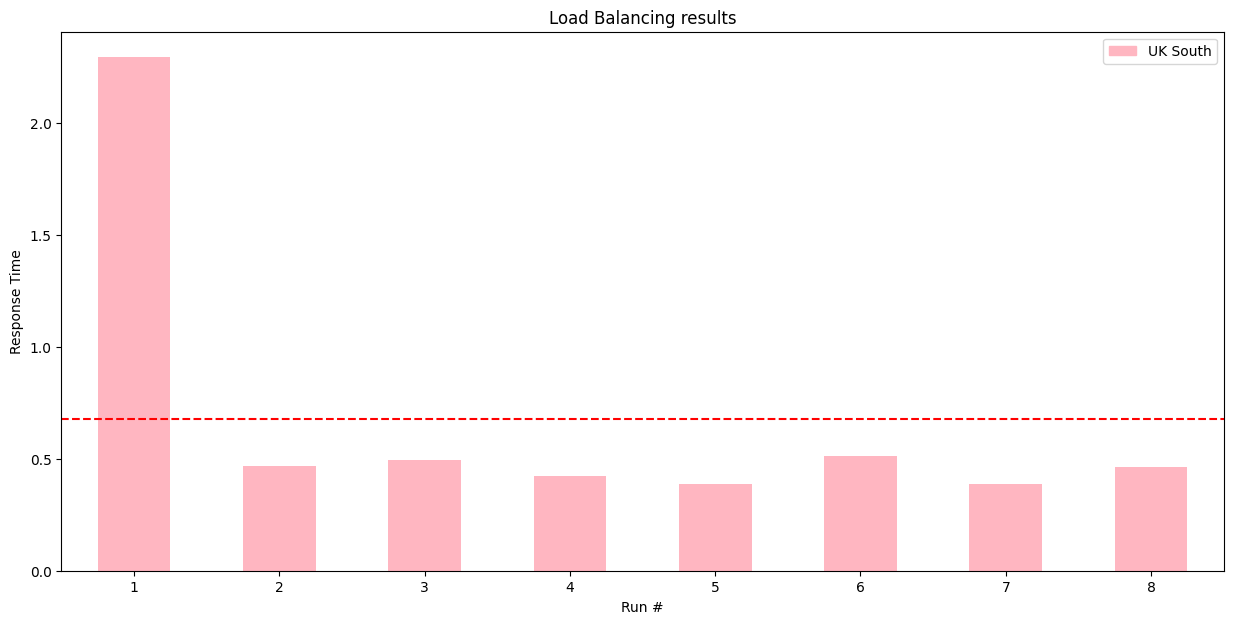

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as pltRectangle
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [15, 7]
df = pd.DataFrame(api_runs, columns = ['Response Time', 'Region'])
df['Run'] = range(1, len(df) + 1)

# Define a color map for each region
color_map = {'UK South': 'lightpink', 'France Central': 'lightblue', 'Sweden Central': 'lightyellow', 'Region3': 'red', 'Region4': 'orange'}  # Add more regions and colors as needed

# Plot the dataframe with colored bars
ax = df.plot(kind = 'bar', x = 'Run', y = 'Response Time', color = [color_map.get(region, 'gray') for region in df['Region']], legend = False)

# Add legend
legend_labels = [pltRectangle((0, 0), 1, 1, color = color_map.get(region, 'gray')) for region in df['Region'].unique()]
ax.legend(legend_labels, df['Region'].unique())

plt.title('Load Balancing results')
plt.xlabel('Run #')
plt.ylabel('Response Time')
plt.xticks(rotation = 0)

average = df['Response Time'].mean()
plt.axhline(y = average, color = 'r', linestyle = '--', label = f'Average: {average:.2f}')

plt.show()

<a id='sdk'></a>
### 🧪 Test the API using the Azure OpenAI Python SDK

Repeat the same test using the Python SDK to ensure compatibility. Note that we do not know what region served the response; we only see that we obtained a response.

In [14]:
import time
from openai import AzureOpenAI

runs = 20
sleep_time_ms = 100

client = AzureOpenAI(
    azure_endpoint = apim_resource_gateway_url,  # type: ignore
    api_key = apim_subscription_key,
    api_version = openai_api_version
)

messages = [
    {"role": "system", "content": "You are a sarcastic, unhelpful assistant."},
    {"role": "user", "content": "Can you tell me the time, please?"}
]

for i in range(runs):
    print(f"▶️ Run {i+1}/{runs}:")

    start_time = time.time()
    raw_response = client.chat.completions.with_raw_response.create(model = openai_model_name, messages = messages) # type: ignore
    response_time = time.time() - start_time
    print(f"⌚ {response_time:.2f} seconds")
    print(f"x-ms-region: \x1b[1;32m{raw_response.headers.get("x-ms-region")}\x1b[0m") # this header is useful to determine the region of the backend that served the request
    response = raw_response.parse()
    if response.usage:
        print(f"Token usage: Total tokens: {response.usage.total_tokens} (Prompt tokens: {response.usage.prompt_tokens} & Completion tokens: {response.usage.completion_tokens})")
    print(f"💬 {response.choices[0].message.content}\n")

    time.sleep(sleep_time_ms/1000)


▶️ Run 1/20:


InternalServerError: Error code: 503

<a id='clean'></a>
### 🗑️ Clean up resources

When you're finished with the lab, you should remove all your deployed resources from Azure to avoid extra charges and keep your Azure subscription uncluttered.
Use the [clean-up-resources notebook](clean-up-resources.ipynb) for that.